**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**May, 2022**

Here I study the DE genes of Explant vs Freash tissue.


----

# Notebook to run differential expression between fresh tissue and day 2 (48h) explants


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata

import matplotlib.pyplot as plt
import matplotlib as mpl


#For TF-IDF
import episcanpy as epi
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/integrated/fetalSurgicalSubset/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bamnostic           NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
episcanpy           0.3.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jup

'/opt/conda/bin/python'

In [4]:
def identityTransfer(adata_CellsNewID, adata, field='identity'):
    
    '''
    Function to transfer the value in a .obs column, modifying only the cells included in adata_CellsNewID
    
    Parameters:
        adata_CellsNewID: anndata object with cells. These should have in their .obs[field] the new values to be transfer to adata
        adata: anndata object to modify. The value in .obs[field] will be modifies for all the cells in adata_CellsNewID
        field: column name in .obs to operate in.
        
     Return:
        anndata object with the metadata modified
        
    '''
    
    #converting categorical into strings to introduce new categories
    adata.obs[field]=adata.obs[field].astype("string")


    #assigning the new categories to the cells in adata
    for cell in adata_CellsNewID.obs.index:
        adata.obs[field][cell] = adata_CellsNewID.obs[field][cell]

    #Returning strings into categorical 
    adata.obs[field]=adata.obs[field].astype("category")
    
    return(adata)

In [5]:
def runTF_IDF(adata, groupby, method='wilcoxon'):
    
    '''
    Function to run TF-IDF and DE analysis. TF-IDF means term-frequency times inverse document-frequency. 
    Its goal is to scale down the impact of tokens that occur very frequently (i.e. less informative)
    than features that occur in a small fraction of the training corpus.
    The the function applies a DE analysis.
    
    Parameters:
        adata: anndata object with cells.
        groupby: column name in .obs to make the DE comparison.
        method: method to use for Differential expression.
    
    Return:
        anndata object with the DE genes stored in adata.uns['rank_genes_groups']
        
    '''
    
    
    counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)


    #-- Binarize counts matrix (1 if expressed, 0 otherwise)
    adata_bin = epi.pp.binarize(counts, copy=True)
    adata_bin.X.shape


    #-- Compute TF-IDF
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(adata_bin.X.T)
    adata_bin.X = tfidf.T
    adata_bin.X.shape


    #-- Compute Mann-Withney test with scanpy
    sc.tl.rank_genes_groups(adata_bin, groupby= groupby, use_raw=False, method=method)

    return(adata_bin)

In [6]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [7]:
sc.set_figure_params(figsize=(7,7))

## Loading data

In [8]:
#adata_raw=sc.read('../results/scVI/S9_scVIintegrated_fetalSurgSubset_adata_latent20_Raw_20220523.h5ad')
adata=sc.read('../results/scVI/S9_scVIintegrated_fetalSurgSubset_adata_latent20_20220523.h5ad')

In [9]:
### ---- Color palette
###

#DF with the row names as the identity of the cells
colors_final_df = pd.DataFrame(index = np.unique(adata.obs['identity']))


#Assign each color per cell type under the column color
colors_final_df.loc['EVT_1', 'color'] = '#bb7784'
colors_final_df.loc['EVT_2', 'color'] = '#884451'
colors_final_df.loc['Endo f', 'color'] = '#ef9708'
colors_final_df.loc['F1', 'color'] = '#c6dec7'
colors_final_df.loc['F1_p', 'color'] = '#8e9f8f'
colors_final_df.loc['F2', 'color'] = '#8fe08c'
colors_final_df.loc['HB', 'color'] = '#76d7ea'
colors_final_df.loc['M3', 'color'] = '#ff5800'
colors_final_df.loc['SCT', 'color'] = '#d6bcc0'
colors_final_df.loc['VCT', 'color'] = '#7d87b9'
colors_final_df.loc['VCT_CCC', 'color'] = '#e7a3c8'
colors_final_df.loc['VCT_fusing', 'color'] = '#b53279'
colors_final_df.loc['VCT_p', 'color'] = '#e07b91'
colors_final_df.loc['iEVT', 'color'] = '#510058'


colors_final_dict= colors_final_df.to_dict()['color']

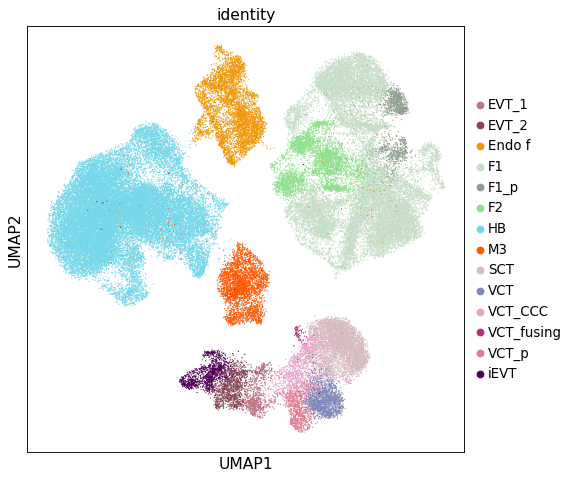

In [10]:
sc.pl.umap(adata,  color=['identity'], palette= colors_final_dict, legend_fontsize=12, size=5)

## Comparison of explants vs fresh tissue

As we have different cell types, I will do paired-comparison of explant vs fresh, per cell type

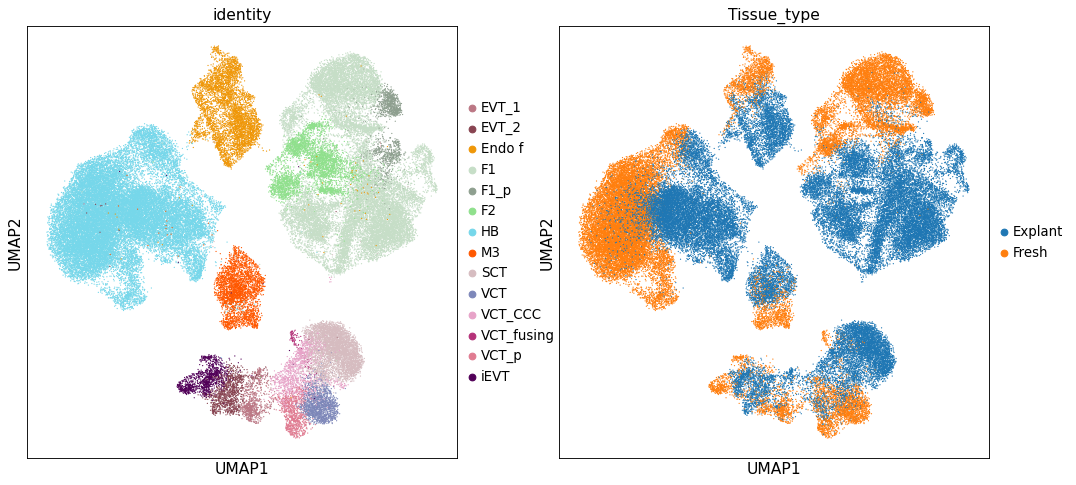

In [12]:
sc.pl.umap(adata, color=['identity','Tissue_type' ],legend_fontsize=12, size=5)

### Cell propotions

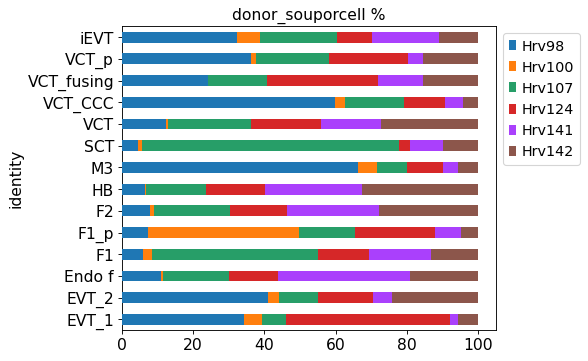

In [13]:
Barplot('donor_souporcell', adata, var='identity', height=5)

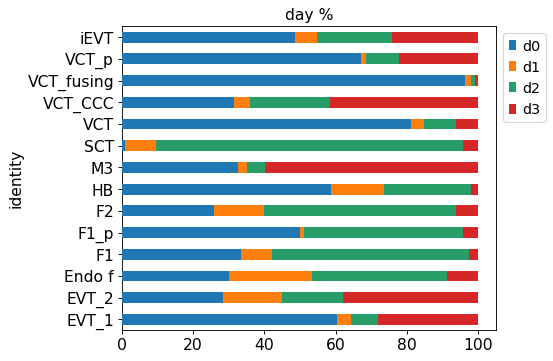

In [14]:
Barplot('day', adata, var='identity', height=5)

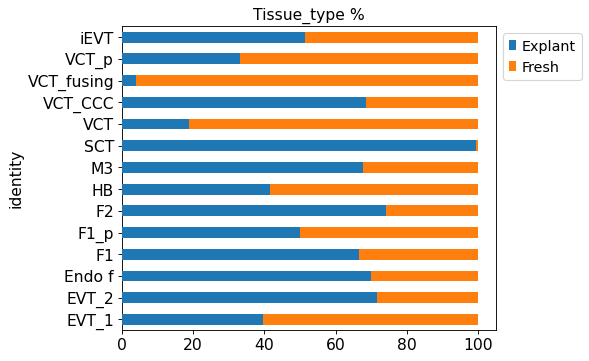

In [15]:
Barplot('Tissue_type', adata, var='identity', height=5)

In [16]:
Explant = adata[adata.obs['Tissue_type'] == 'Explant']
Fresh= adata[adata.obs['Tissue_type'] == 'Fresh']

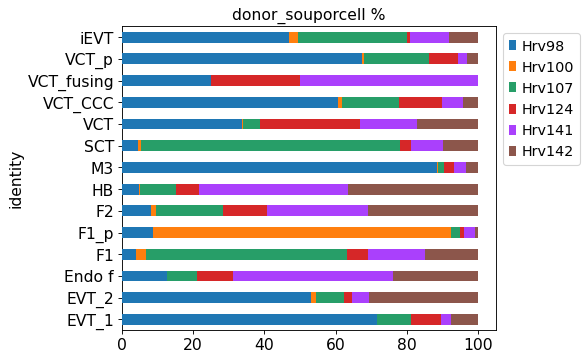

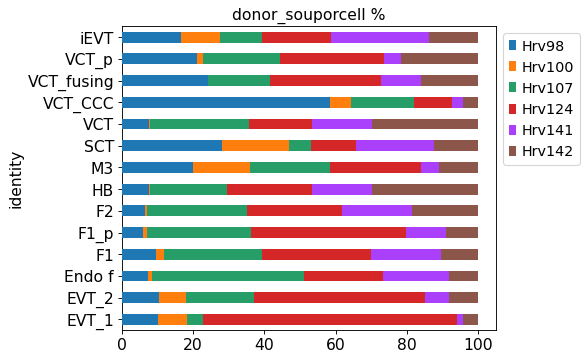

In [17]:
#Barplot proportion of cells per donor, explant and fresh tissue

Barplot('donor_souporcell', Explant, var='identity', height=5, suffix='_explant')
Barplot('donor_souporcell', Fresh, var='identity', height=5, suffix='_fresh')

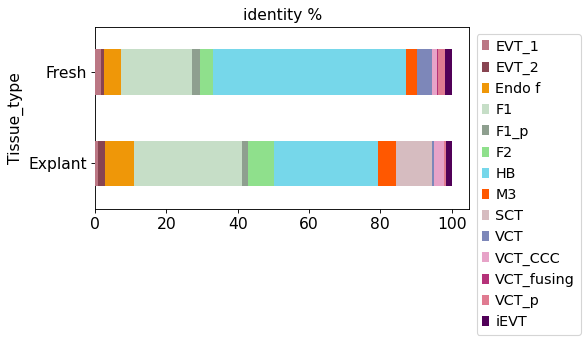

In [22]:
Barplot('identity', adata, var='Tissue_type', height=3, color=colors_final_dict)

## Differentially expressed genes to differentiate clusters


The goal here is to compare the differences between explant and fresh tissue. As these differences will vary a lot among cell types it is better if I perform a cell type-by-cell type comparison, contrasting fresh vs Explant every time.

In [12]:
#Changing the path to save the images
sc.settings.figdir = '../results/images/integrated/fetalSurgicalSubset/DEexplant_vs_fresh/'

In [13]:
#runTF_IDF function
adata.raw=adata.copy()

In [21]:
adata_counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)

#### Endo f

In [14]:
temp_cells = adata[adata.obs['identity_broad'] == 'Endo f']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


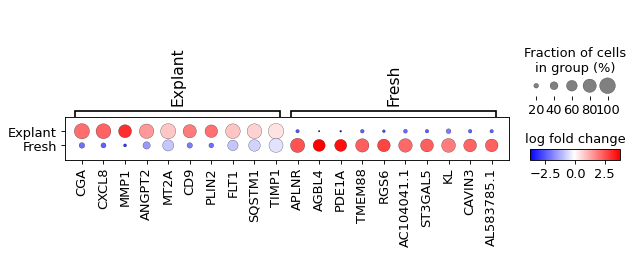

In [15]:
#Plot TF-IDF DE values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False,values_to_plot="logfoldchanges",
                                cmap='bwr', save='tfidf_TissueType_Endof_scanpy.pdf')

In [16]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_endoF.csv', index=False )


In [17]:
sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)
#list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])

,names,scores,logfoldchanges,pvals,pvals_adj
0,CGA,46.268398,2.146348,0.000000e+00,0.000000e+00
1,CXCL8,45.975338,2.331642,0.000000e+00,0.000000e+00
2,MMP1,40.236954,3.101519,0.000000e+00,0.000000e+00
3,PLIN2,35.026554,2.116160,8.872136e-269,3.227782e-265
4,STC1,32.679451,2.791986,3.059325e-234,5.008575e-231
5,TNFRSF12A,32.621307,3.302165,2.045817e-233,3.189819e-230
6,SLC7A11,31.444731,3.286394,4.955037e-217,4.916448e-214
7,SERPINE1,30.171316,2.271475,5.635621e-200,3.926109e-197
8,CCL13,26.282728,2.701491,3.021966e-152,7.979697e-150
9,PTGS2,25.763676,6.853916,2.265241e-146,4.362987e-144


In [18]:
markers=list(sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2)[ 'names'])[0:10]

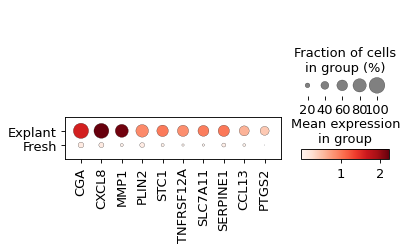

In [19]:
sc.pl.dotplot(temp_cells, markers, groupby='Tissue_type', dendrogram=True, )#,layer='scaled',cmap='bwr', vmin=0, vmax=4

#### HBs

In [29]:
temp_cells = adata[adata.obs['identity_broad'] == 'HB']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:01)


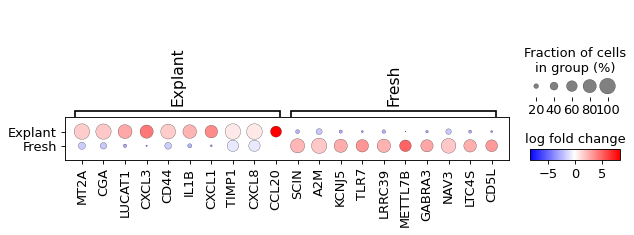

In [35]:
#Plot TF-IDF DE values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False,values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_HBs_scanpy_10.pdf')

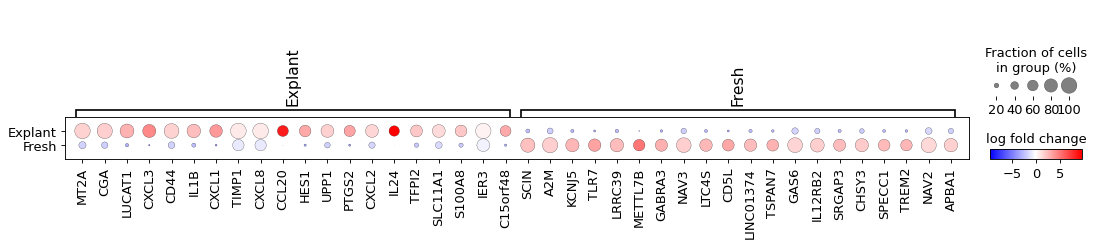

In [36]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=20, dendrogram=False,values_to_plot="logfoldchanges",
                                cmap='bwr',save='rawtfidf_TissueType_HBs_scanpy_20.pdf')

In [37]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_HB.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,LUCAT1,112.365242,2.850097,0.0,0.0
1,CXCL3,109.966568,4.423646,0.0,0.0
2,IL1B,104.333839,2.447733,0.0,0.0
3,CXCL1,102.290527,3.823945,0.0,0.0
4,CCL20,89.580460,8.419663,0.0,0.0
5,HES1,88.648773,3.253075,0.0,0.0
6,PTGS2,85.830261,3.352605,0.0,0.0
7,IL24,83.385292,9.517932,0.0,0.0
8,TFPI2,82.806473,2.075807,0.0,0.0
9,S100A8,81.517418,2.080034,0.0,0.0


In [12]:
markers = ["TLR1","TLR2","TLR4","TLR5","TLR7",
           "IFNGR1","IFNGR2","IFNAR2","IFNAR1", 
           "IL6","IL24","IL1B",
           "CXCL1","CXCL3","CXCL8","CXCL16","CCL3","CCL4","CCL20",
          "C1QA","C1QB","C1QC","C1RL","C1S","C2"]


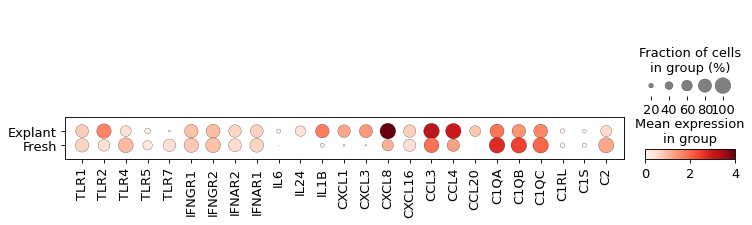

In [90]:
temp_cells = adata[adata.obs['identity_broad'] == 'HB']


sc.pl.dotplot(temp_cells, markers, groupby='Tissue_type', dendrogram=True, 
              vmin=0, vmax=4,save='genesDefence_TissueType_HBs.pdf')#,layer='scaled',cmap='bwr', )

#### M3

In [77]:
temp_cells = adata[adata.obs['identity_broad'] == 'M3']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


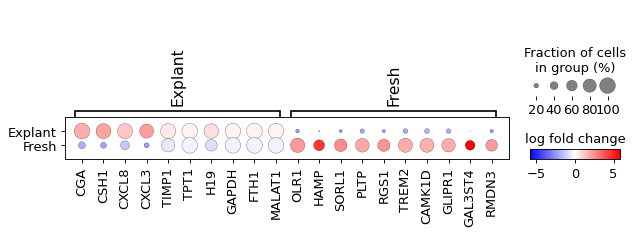

In [39]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_M3_scanpy_10.pdf')

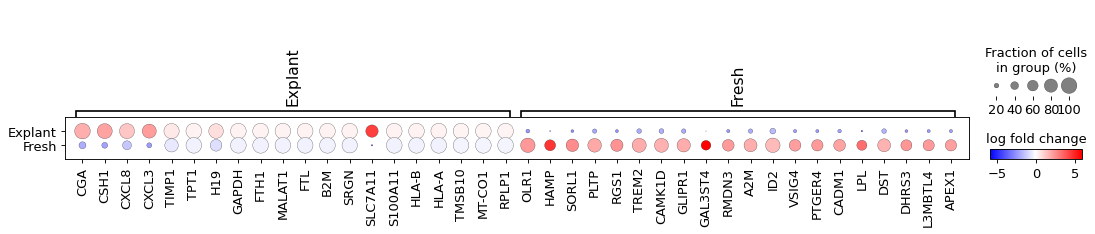

In [40]:
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=20, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_M3_scanpy_20.pdf')

In [41]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_M3.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)


,names,scores,logfoldchanges,pvals,pvals_adj
0,CSH1,38.737411,2.128104,0.000000e+00,0.000000e+00
1,CXCL3,34.318916,2.256262,4.098581e-258,3.354996e-254
2,SLC7A11,31.263130,4.405121,1.480359e-214,3.462242e-211
3,CXCL5,25.730518,5.937236,5.326432e-146,1.236903e-143
4,S100P,21.539953,2.449347,6.577330e-103,1.011087e-100
5,THBS1,17.776257,3.547780,1.079523e-70,1.178228e-68
6,CSH2,16.854584,3.418061,9.708811e-64,9.214365e-62
7,CXCL1,15.732987,3.376957,8.986858e-56,7.283581e-54
8,SLAMF9,13.890452,2.108197,7.237642e-44,4.121428e-42
9,AHRR,12.812448,2.555170,1.396584e-37,5.985385e-36


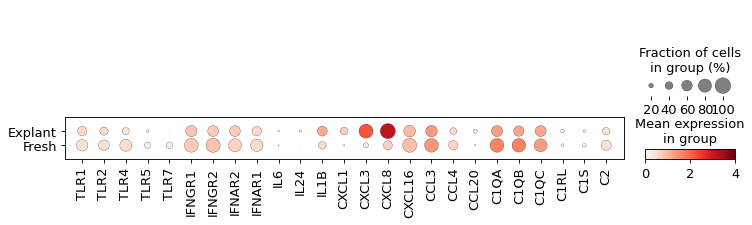

In [91]:
temp_cells = adata[adata.obs['identity_broad'] == 'M3']


sc.pl.dotplot(temp_cells, markers, groupby='Tissue_type', dendrogram=True, 
              vmin=0, vmax=4,save='genesDefence_TissueType_M3.pdf')#,layer='scaled',cmap='bwr', )

#### EVT

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


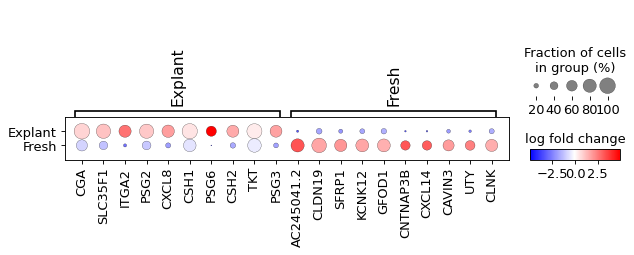

In [20]:
temp_cells = adata[adata.obs['identity_broad'] == 'EVT']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_EVT_scanpy.pdf')

In [21]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_EVT.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)


,names,scores,logfoldchanges,pvals,pvals_adj
0,ITGA2,30.685459,2.755022,8.897625e-207,7.283373e-203
1,PSG6,26.085199,4.989397,5.367241e-150,1.952662e-146
2,INHBA,17.859053,2.969298,2.457774e-71,1.283491e-69
3,CXCL3,17.244818,4.375122,1.223980e-66,5.725253e-65
4,CSHL1,16.763390,3.130533,4.521012e-63,1.930006e-61
5,CCL20,15.473166,6.550722,5.265298e-54,1.816666e-52
6,IL24,15.196386,7.432679,3.736714e-52,1.227194e-50
7,IL32,14.071880,2.389400,5.654565e-45,1.597475e-43
8,PTGS2,13.681559,4.596426,1.308573e-42,3.435974e-41
9,MMP1,13.537728,7.770786,9.364039e-42,2.416129e-40


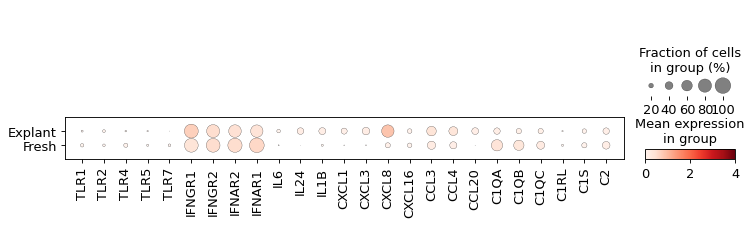

In [18]:
temp_cells = adata[adata.obs['identity_broad'] == 'EVT']


sc.pl.dotplot(temp_cells, markers, groupby='Tissue_type', dendrogram=True,
              vmin=0, vmax=4,save='genesDefence_TissueType_EVT.pdf')#,layer='scaled',cmap='bwr', )

#### SCT

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


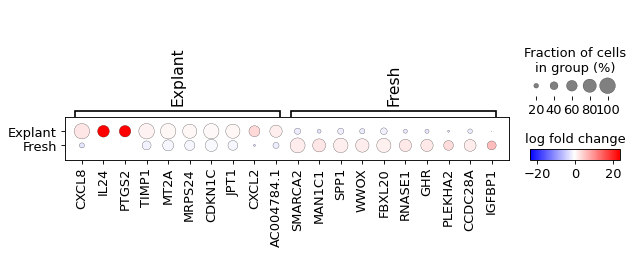

In [22]:
temp_cells = adata[adata.obs['identity_broad'] == 'SCT']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_SCT_scanpy.pdf')

In [23]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_SCT.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)



,names,scores,logfoldchanges,pvals,pvals_adj
0,CXCL8,8.739347,2.376235,2.344600e-18,7.676923e-14
1,IL24,6.627285,23.616081,3.419179e-11,5.597709e-07
2,PTGS2,6.459595,23.597221,1.049836e-10,1.145826e-06
3,CXCL2,5.797841,3.659714,6.717419e-09,1.999531e-05
4,CCL20,5.696725,23.506273,1.221306e-08,3.076095e-05
5,OSGIN1,5.075270,3.236737,3.869471e-07,3.894863e-04


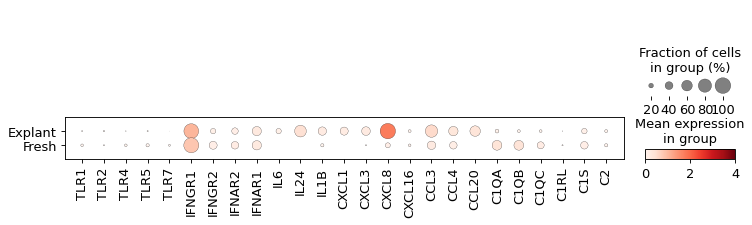

In [19]:
temp_cells = adata[adata.obs['identity_broad'] == 'SCT']


sc.pl.dotplot(temp_cells, markers, groupby='Tissue_type', dendrogram=True,
              vmin=0, vmax=4,save='genesDefence_TissueType_SCT.pdf')#,layer='scaled',cmap='bwr', )

In [ ]:
markers = ["ANGPT1","ANGPT2","ITGA5","SVEP1","ITGB1","KDR","VEGFA","VEGFB",
          "ESR1","ESR2","CGB3","CGB5","CGB7","CGB8","CSHL1","CGA","IGF1","IGF1R","IRS1","IRS2"]




#### VCT

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


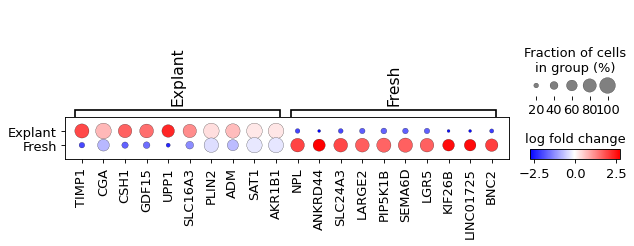

In [24]:
temp_cells = adata[adata.obs['identity_broad'] == 'VCT']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_VCT_scanpy.pdf')

In [25]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_VCT.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,UPP1,33.696453,2.333843,6.515357e-249,4.266647e-245
1,LUCAT1,26.685356,3.848696,6.961809e-157,1.461221e-154
2,PSG2,23.722916,3.215011,2.092143e-124,2.322137e-122
3,PAM,23.321606,2.225021,2.676663e-120,2.730280e-118
4,PNCK,23.064100,2.156606,1.062015e-117,1.034928e-115
5,INHBA,22.141907,3.702621,1.248422e-108,1.029650e-106
6,VEGFA,21.911657,2.800863,2.011309e-106,1.606251e-104
7,PSG6,21.383533,4.156820,1.901736e-101,1.421656e-99
8,KISS1,21.166666,2.453575,1.937880e-99,1.400707e-97
9,FOSL1,20.794632,2.728626,4.840446e-96,3.267850e-94


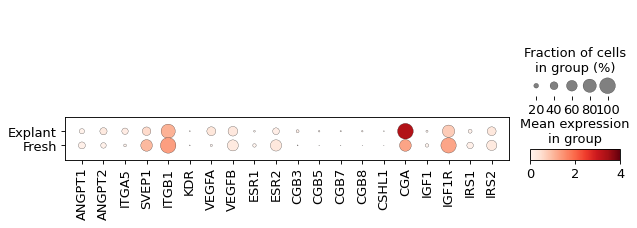

In [41]:
temp_cells = adata[adata.obs['identity_broad'] == 'VCT']


sc.pl.dotplot(temp_cells, markers, groupby='Tissue_type', dendrogram=True,vmin=0, vmax=4)
              #vmin=0, vmax=4,save='genesRelevant_TissueType_HBs.pdf')#,layer='scaled',cmap='bwr', )

#### F1

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:22)


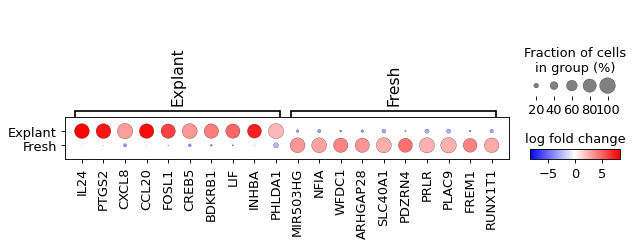

In [167]:
temp_cells = adata[adata.obs['identity_broad'] == 'F1']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_F1_scanpy.pdf')

In [168]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_F1.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,IL24,81.260834,8.253127,0.0,0.0
1,PTGS2,80.887184,7.556963,0.0,0.0
2,CXCL8,79.870331,3.173834,0.0,0.0
3,CCL20,79.213715,7.921703,0.0,0.0
4,FOSL1,77.243958,6.145444,0.0,0.0
5,CREB5,77.100334,3.358550,0.0,0.0
6,BDKRB1,75.773270,4.222601,0.0,0.0
7,LIF,75.728432,4.909781,0.0,0.0
8,INHBA,75.210625,7.175975,0.0,0.0
9,PHLDA1,74.669037,2.321601,0.0,0.0


#### F1_p

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


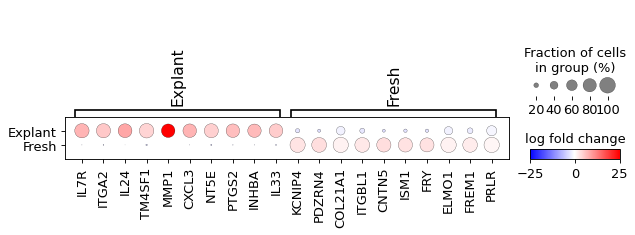

In [169]:
temp_cells = adata[adata.obs['identity_broad'] == 'F1_p']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_F1p_scanpy.pdf')

In [170]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_F1p.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,IL7R,25.346933,7.386285,9.714162e-142,1.536052e-137
1,ITGA2,24.587927,5.462752,1.700755e-133,1.344659e-129
2,IL24,24.352308,8.878337,5.479853e-131,2.888339e-127
3,TM4SF1,24.217606,4.335592,1.451672e-129,6.558447e-126
4,MMP1,23.739668,25.286877,1.404864e-124,4.442882e-121
5,CXCL3,23.627552,7.445608,2.008471e-123,5.774354e-120
6,NT5E,23.585405,4.670705,5.441673e-123,1.434107e-119
7,PTGS2,23.418564,6.398653,2.765181e-121,6.246346e-118
8,INHBA,23.100031,6.872267,4.626734e-118,9.754698e-115
9,IL33,22.963030,4.940803,1.091896e-116,2.158201e-113


#### F2

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


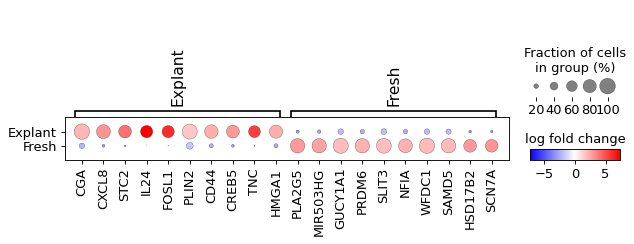

In [171]:
temp_cells = adata[adata.obs['identity_broad'] == 'F2']
adata_bin= runTF_IDF(temp_cells, groupby='Tissue_type', method='wilcoxon')

#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata_bin, n_genes=10, dendrogram=False, values_to_plot="logfoldchanges",
                                cmap='bwr', save='rawtfidf_TissueType_F2_scanpy.pdf')

In [172]:
# CHunk to save the DF of DE genes. I am only including genes with a log2fc>0.5
dedf = sc.get.rank_genes_groups_df(adata_bin, group='Explant', log2fc_min=0.5, pval_cutoff=0.001)
dedf.to_csv('../results/tables/DEexplant_vs_fresh/deTFIDF_F2.csv', index=False )

sc.get.rank_genes_groups_df(adata_bin, group='Explant', pval_cutoff=0.001, log2fc_min=2).head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,CGA,28.142269,2.107826,2.979676e-174,9.423225e-170
1,CXCL8,26.748569,3.045012,1.283026e-157,2.028785e-153
2,STC2,25.261778,4.080349,8.407652e-141,5.317840e-137
3,IL24,25.056513,7.351918,1.482604e-138,7.814560e-135
4,FOSL1,24.714628,6.132536,7.446676e-135,2.943764e-131
5,CD44,23.972513,2.344313,5.382609e-127,1.309423e-123
6,CREB5,23.940613,2.970507,1.157360e-126,2.614394e-123
7,TNC,23.769812,5.582486,6.856354e-125,1.275484e-121
8,HMGA1,23.519308,2.350291,2.588409e-122,4.308339e-119
9,RUNX1,22.631363,2.008824,2.129190e-113,2.927636e-110
